In [15]:
!pip install -q numpy torch scikit-learn pandas shap matplotlib seaborn

# Gender Classification: Model Training and Evaluation

In [16]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [17]:
import torch.nn as nn


class GenderClassifier(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.fc3 = nn.Linear(hidden2_size, output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

In [18]:
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset, random_split

df = pd.read_csv("data/hr_data_gold.csv")
label = "Gender_Male"
features = [c for c in df.columns if c != label]
X = torch.tensor(df[features].values, dtype=torch.float32).to(device)
y = torch.tensor(df[label].values, dtype=torch.long).to(device)
ds = TensorDataset(X, y)
train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size
ds_train, ds_test = random_split(ds, [train_size, test_size])
all_loader = DataLoader(ds, batch_size=1, shuffle=False)
train_loader = DataLoader(ds_train, batch_size=32, shuffle=True)
test_loader = DataLoader(ds_test, batch_size=1, shuffle=True)

In [19]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

try:
    model = torch.load("model_96_48_b32_e300.pt")
except Exception:
    model = GenderClassifier(len(features), 96, 48, 2).to(device)
    train_accuracy_log, test_accuracy_log = [], []
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    epochs = 300
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
        with torch.no_grad():
            model.eval()
            train_features, train_labels = ds_train[:][0], ds_train[:][1]
            train_pred = model(train_features).argmax(dim=1)
            train_accuracy = accuracy_score(train_labels.cpu(), train_pred.cpu())
            train_accuracy_log.append(train_accuracy)
            test_features, test_labels = ds_test[:][0], ds_test[:][1]
            test_pred = model(test_features).argmax(dim=1)
            test_accuracy = accuracy_score(test_labels.cpu(), test_pred.cpu())
            test_accuracy_log.append(test_accuracy)
        if epoch % 5 == 0:
            print(f"Progress: {epoch / epochs * 100:.1f} %")

Progress: 0.0 %
Progress: 1.7 %
Progress: 3.3 %
Progress: 5.0 %
Progress: 6.7 %
Progress: 8.3 %
Progress: 10.0 %
Progress: 11.7 %
Progress: 13.3 %
Progress: 15.0 %
Progress: 16.7 %
Progress: 18.3 %
Progress: 20.0 %
Progress: 21.7 %
Progress: 23.3 %
Progress: 25.0 %
Progress: 26.7 %
Progress: 28.3 %
Progress: 30.0 %
Progress: 31.7 %
Progress: 33.3 %
Progress: 35.0 %
Progress: 36.7 %
Progress: 38.3 %
Progress: 40.0 %
Progress: 41.7 %
Progress: 43.3 %
Progress: 45.0 %
Progress: 46.7 %
Progress: 48.3 %
Progress: 50.0 %
Progress: 51.7 %
Progress: 53.3 %
Progress: 55.0 %
Progress: 56.7 %
Progress: 58.3 %
Progress: 60.0 %
Progress: 61.7 %
Progress: 63.3 %
Progress: 65.0 %
Progress: 66.7 %
Progress: 68.3 %
Progress: 70.0 %
Progress: 71.7 %
Progress: 73.3 %
Progress: 75.0 %
Progress: 76.7 %
Progress: 78.3 %
Progress: 80.0 %
Progress: 81.7 %
Progress: 83.3 %
Progress: 85.0 %
Progress: 86.7 %
Progress: 88.3 %
Progress: 90.0 %
Progress: 91.7 %
Progress: 93.3 %
Progress: 95.0 %
Progress: 96.7 %
Pro

In [21]:
torch.save(model, "model_96_48_b32_e300.pt")

## Model Evaluation

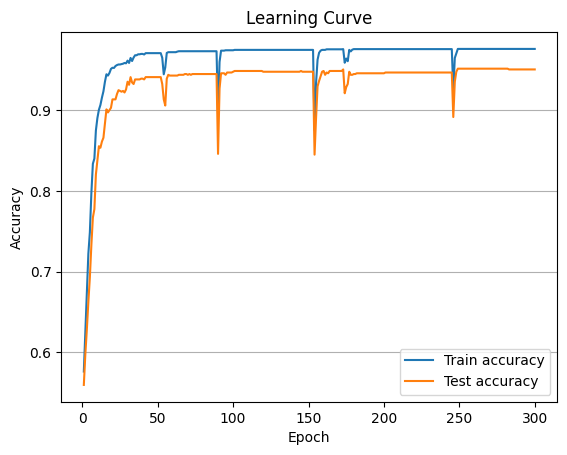

In [22]:
import matplotlib.pyplot as plt

x = list(range(1, epochs + 1))
plt.plot(x, train_accuracy_log, label="Train accuracy")
plt.plot(x, test_accuracy_log, label="Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Learning Curve")
plt.grid(axis="y")
plt.legend()
plt.show()

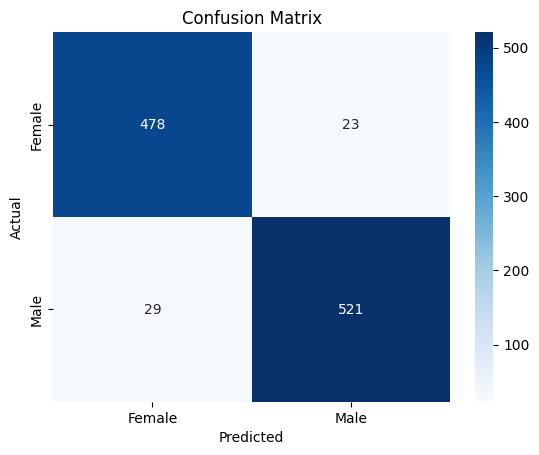

Accuracy:  0.9505
Precision: 0.9577
Recall:    0.9473
F1 Score:  0.9525


In [23]:
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns

model.eval()
all_preds, all_labels, all_results = [], [], []
with torch.no_grad():
    for X, y in test_loader:
        outputs = model.cpu()(X.cpu())
        all_results.append(outputs[0])
        preds = torch.argmax(outputs, dim=1)
        all_labels.append(y.cpu())
        all_preds.append(preds)
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Female", "Male"],
    yticklabels=["Female", "Male"],
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

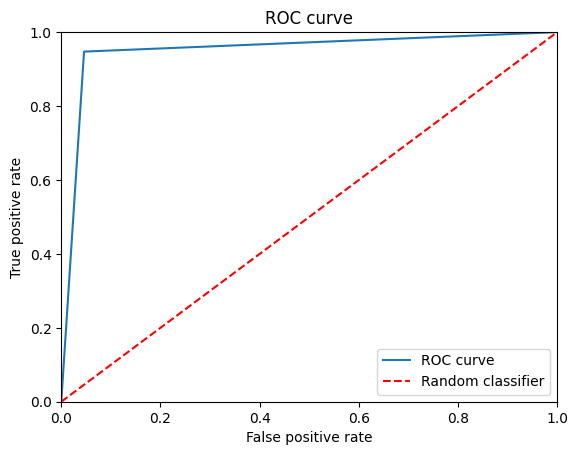

In [24]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
auc_score = auc(fpr, tpr)
plt.plot(fpr, tpr, label="ROC curve")
plt.plot([0, 1], [0, 1], color="red", linestyle="--", label="Random classifier")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.show()

## Benchmark: Predefined Models

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

df = pd.read_csv("data/hr_data_gold.csv")
feature_names = [c for c in df.columns if c != "Gender_Male"]
label_name = "Gender_Male"
X_train, X_test, y_train, y_test = train_test_split(
    df[feature_names], df[label_name], test_size=0.2, random_state=42
)
models = {
    "SVC": SVC(probability=True),
    "RandomForestClassifier": RandomForestClassifier(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "LogisticRegression": LogisticRegression(),
    "GaussianNB": GaussianNB(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
}
for name, m in models.items():
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} accuracy: {acc:.4f}")

SVC accuracy: 0.7935
RandomForestClassifier accuracy: 0.9981
KNeighborsClassifier accuracy: 0.7374
LogisticRegression accuracy: 0.5671
GaussianNB accuracy: 0.5319
DecisionTreeClassifier accuracy: 0.9838


## Hyperparameter Optimization: Random Search

In [27]:
import random

param_ranges = {
    "n_estimators": list(range(1, 500)),
    "max_depth": list(range(1, len(df.columns))),
    "min_samples_split": list(range(2, 10)),
    "max_features": ["sqrt", "log2"],
}
best_config, best_model, best_accuracy = {}, None, 0
for gen in range(100):
    params = {k: random.choice(v) for k, v in param_ranges.items()}
    model = RandomForestClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    if acc > best_accuracy:
        best_accuracy = acc
        best_config = params
        best_model = model
print(f"Best config: {best_config}")
print(f"Best accuracy: {best_accuracy:.4f}")

Best config: {'n_estimators': 463, 'max_depth': 17, 'min_samples_split': 3, 'max_features': 'log2'}
Best accuracy: 0.9981


## Feature Importance Analysis (SHAP)

In [29]:
import shap

medianes = X_train.median().values.reshape((1, X_train.shape[1]))
f = lambda x: best_model.predict(x)
explainer = shap.Explainer(f, medianes, feature_names=features)
shap_values = explainer(X_test.iloc[0:1000, :])

/home/marcin/Projects/WSEI-ML_and_AI_Programming_Libraries/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/marcin/Projects/WSEI-ML_and_AI_Programming_Libraries/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/marcin/Projects/WSEI-ML_and_AI_Programming_Libraries/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/home/marcin/Projects/WSEI-ML_and_AI_Programming_Libraries/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warning

KeyboardInterrupt: 

In [13]:
shap.plots.waterfall(shap_values[0])

In [14]:
shap.plots.beeswarm(shap_values[:100], max_display=len(features))

In [15]:
shap.plots.heatmap(shap_values)